In [1]:
# To tylko theme ,którego używam jeżeli nie użył Pan environment.yml proszę wykomentować
from jupyterthemes import jtplot
jtplot.style('chesterish')

# Diagnostyka Choroby Serca
Używając danych z https://www.kaggle.com/ronitf/heart-disease-uci#heart.csv spróbuje stworzyć model zdolny do diagnozowania choroby serca na podstawie danych medycznych takich jak wiek czy ciśnienie.

# Kryteria Akceptacji
Model osiąga accuracy > 90%

# Słownik Pojęć
1. age - age in years 
2. sex - (1 = male; 0 = female) 
3. cp - chest pain type 
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease
4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)
    * anything above 130-140 is typically cause for concern
5. chol - serum cholestoral in mg/dl 
    * serum = LDL + HDL + .2 * triglycerides
    * above 200 is cause for concern
6. fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
    * '>126' mg/dL signals diabetes
7. restecg - resting electrocardiographic results
    * 0: Nothing to note
    * 1: ST-T Wave abnormality
        - can range from mild symptoms to severe problems
        - signals non-normal heart beat
    * 2: Possible or definite left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach - maximum heart rate achieved 
9. exang - exercise induced angina (1 = yes; 0 = no) 
10. oldpeak - ST depression induced by exercise relative to rest 
    * looks at stress of heart during excercise
    * unhealthy heart will stress more
11. slope - the slope of the peak exercise ST segment
    * 0: Upsloping: better heart rate with excercise (uncommon)
    * 1: Flatsloping: minimal change (typical healthy heart)
    * 2: Downslopins: signs of unhealthy heart
12. ca - number of major vessels (0-3) colored by flourosopy 
    * colored vessel means the doctor can see the blood passing through
    * the more blood movement the better (no clots)
13. thal - thalium stress result
    * 1,3: normal
    * 6: fixed defect: used to be defect but ok now
    * 7: reversable defect: no proper blood movement when excercising 
14. target - have disease or not (1=yes, 0=no) (= the predicted attribute)
#### Opisy z strony gdzie dataset został oryginalnie udostępniony, nie znam dokładnych terminów medycznych dlatego zrezygnowałem z tłumaczenia tej części

# Narzędzia
1. Pandas
2. Matplotlib + Seaborn
3. NumPy
4. SciKitLearn
#### Na ćwiczeniach był głównie Tensorflow/Keras więc tutaj dla odmiany skupię się na możliwościach  Pandas i SciKitLearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

In [3]:
df = pd.read_csv("./heart-disease.csv")

## Eksploracja Danych

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
# 1 - chory 0 - zdrowy
df["target"].value_counts()

1    165
0    138
Name: target, dtype: int64

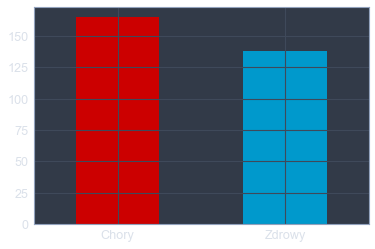

In [6]:
# Graficznie lepiej widać, że dane są zbalansowane
df["target"].value_counts().plot(kind="bar", color=["#CC0000", "#0099CC"])
plt.xticks(np.arange(0, 1, step=1))
plt.xticks(np.arange(2), ('Chory', 'Zdrowy'))
plt.xticks(np.arange(2), rotation = 0)
plt.show()

In [7]:
# Czy brakuje danych?
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
# Ogólne informacje, czy istnieją oczywiste outlier'y?
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


# Szukanie Wzorców

In [9]:
# sex / target - czy płeć ma znaczny wpływ?
# 1 - mężczyzna 0 - kobieta
# 1 - chory 0 - zdrowy
df.sex.value_counts()

1    207
0     96
Name: sex, dtype: int64

In [10]:
pd.crosstab(df.target, df.sex)

sex,0,1
target,,
0,24,114
1,72,93


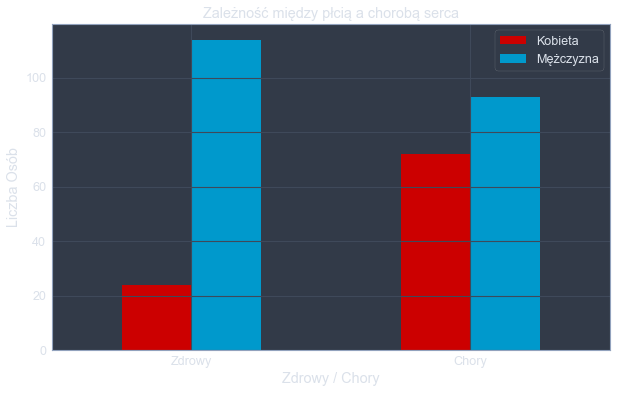

In [11]:
pd.crosstab(df.target, df.sex).plot(kind="bar", figsize=(10, 6), color=["#CC0000", "#0099CC"])
plt.title("Zależność między płcią a chorobą serca")
plt.legend(["Kobieta", "Mężczyzna"])
plt.xlabel("Zdrowy / Chory")
plt.ylabel("Liczba Osób")

plt.xticks(np.arange(0, 1, step=1))
plt.xticks(np.arange(2), ('Zdrowy', 'Chory'))
plt.xticks(np.arange(2), rotation = 0)
plt.show()
# +- 70% kobiet +- 50% mężczyzn ma chorobe serca => +- 60% wszystkich pacjentów ma chorobe serca
# jeżeli pacjent jest kobietą to jest wieksza szansa ,że ma chorobe serca

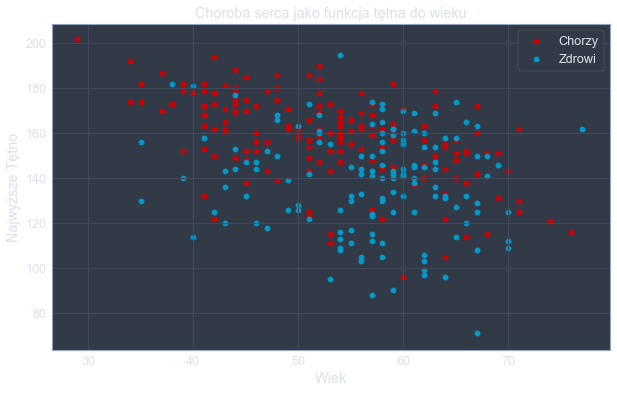

In [12]:
# age / max heart rate + target
plt.figure(figsize=(10,6))
# Chorzy
plt.scatter(
    df["age"][df.target == 1], 
    df["thalach"][df.target == 1], 
    c = "#CC0000")
# Zdrowi
plt.scatter(
    df["age"][df.target == 0],
    df["thalach"][df.target == 0],
    c = "#0099CC"
)

plt.title("Choroba serca jako funkcja tętna do wieku")
plt.xlabel("Wiek")
plt.ylabel("Najwyższe Tętno")
plt.legend(["Chorzy", "Zdrowi"])
plt.show()
# Wzorce nie są oczywiste - nie można poprowadzić prostej linii
# Widać jedynie tendencje im wyższy wiek tym niższe tętno

Text(0.5, 0, 'Wiek')

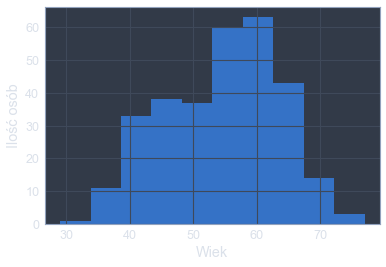

In [13]:
df["age"].plot.hist();
plt.ylabel("Ilość osób")
plt.xlabel("Wiek")
# dość blisko rozkładu normalnego jednak widać przewage wieków od 53 do 62 lat

chest pain / target  
skopiowane ze słownika na potrzeby szybkiego dostępu
3. cp - chest pain type 
    * 0: Typical angina: chest pain related decrease blood supply to the heart
    * 1: Atypical angina: chest pain not related to heart
    * 2: Non-anginal pain: typically esophageal spasms (non heart related)
    * 3: Asymptomatic: chest pain not showing signs of disease

In [14]:
pd.crosstab(df.cp, df.target)
# dane pokazują zależność między chorobą a bólami zwykle z nią niezwiązanymi

target,0,1
cp,,
0,104,39
1,9,41
2,18,69
3,7,16


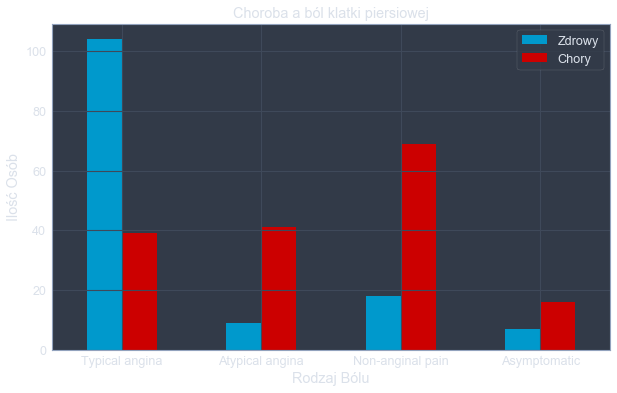

In [15]:
pd.crosstab(df.cp, df.target).plot(
    kind="bar",
    figsize=(10,6),
    color=["#0099CC", "#CC0000"]
)

plt.title("Choroba a ból klatki piersiowej")
plt.xlabel("Rodzaj Bólu")
plt.ylabel("Ilość Osób")
plt.legend(["Zdrowy", "Chory"])

plt.xticks(np.arange(0, 1, step=.25))
plt.xticks(np.arange(2), ('Typical angina', 'Atypical angina', 'Non-anginal pain', 'Asymptomatic'))
plt.xticks(np.arange(4), rotation = 0)
plt.show()

In [16]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


(14.0, 0.0)

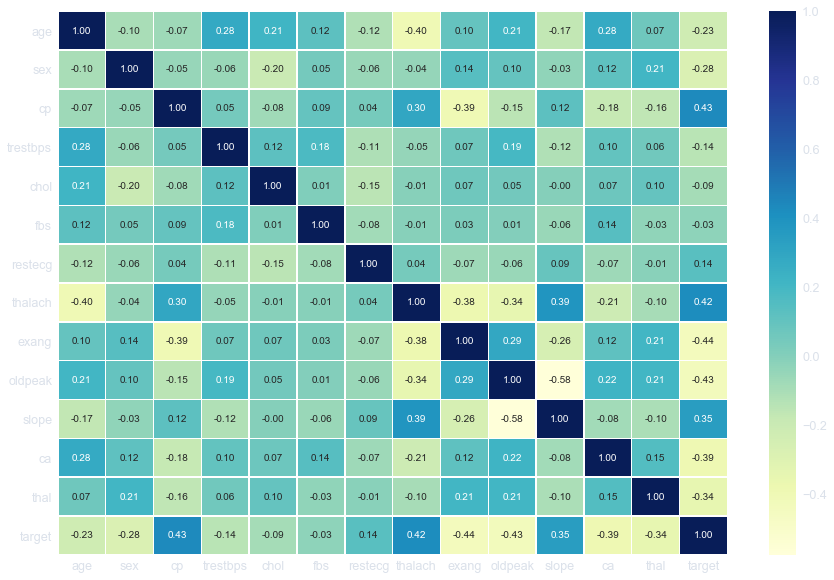

In [17]:
# matryca korelacji
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix,
                annot=True,
                linewidths=0.5,
                fmt=".2f",
                cmap="YlGnBu")
# błąd matplotliba, ucina trzeba przesunąć
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Modelowanie

In [18]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [19]:
# Niezależne, zależna
X = df.drop("target", axis = 1)
y = df["target"]

In [20]:
# Podział
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [21]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
132,42,1,1,120,295,0,1,162,0,0.0,2,0,2
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3
196,46,1,2,150,231,0,1,147,0,3.6,1,0,2
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2
176,60,1,0,117,230,1,1,160,1,1.4,2,2,3


In [22]:
# testowanie modelu
models = {
    "Logistic Regression" : LogisticRegression(),
    "KNN" : KNeighborsClassifier(),
    "Random Forest" : RandomForestClassifier()
    }
def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Testowanie różnych modeli
    models: dict
    X_train: dataframe
    X_test: dataframe
    y_train: series
    y_test: series
    """
    np.random.seed(42)
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [23]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores
# coś chyba nie optymalnie robie, ale działa

C:\Users\BennyKayer\Miniconda3\envs\Heart_Disease\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'Logistic Regression': 0.8852459016393442,
 'KNN': 0.6885245901639344,
 'Random Forest': 0.8360655737704918}

## Wyniki

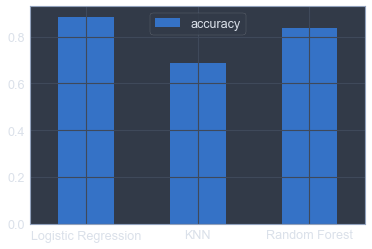

In [24]:
model_compare = pd.DataFrame(model_scores, index=["accuracy"])
model_compare.T.plot.bar()
plt.xticks(np.arange(3), rotation = 0)
plt.show()
# KNN radzi sobie dość słabo...

# Optymalizacja Modelu

In [25]:
# KNN n_neighbours - poszukiwanie optymalnej wartości
train_scores = []
test_scores = []
neighbours = range(1,21)
knn = KNeighborsClassifier()

for i in neighbours:
    knn.set_params(n_neighbors = i)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

Najwyższa celność modelu to: 75.41%


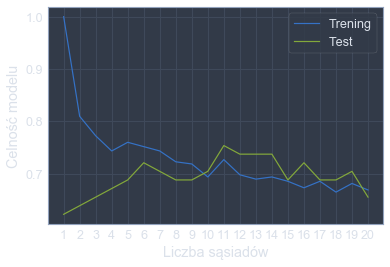

In [26]:
plt.plot(neighbours, train_scores, label="Trening")
plt.plot(neighbours, test_scores, label="Test")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Liczba sąsiadów")
plt.ylabel("Celność modelu")
plt.legend()

print(f"Najwyższa celność modelu to: {max(test_scores) * 100:.2f}%")
# 68 -> 75% niewielka poprawa, zobaczymy 2 pozostałe

In [27]:
#logistic regression
log_reg_grid = {"C": np.logspace(-4,4,20),
                "solver" : ["liblinear"]}
#random forest
rf_grid = {"n_estimators" : np.arange(10, 1000, 50),
          "max_depth" : [None, 3, 5, 10],
           "min_samples_split" : np.arange(2, 20, 2),
           "min_samples_leaf" : np.arange(1, 20, 2)}

In [28]:
np.random.seed(42)
#Setup regression
rs_log_reg = RandomizedSearchCV(LogisticRegression(), 
                                param_distributions = log_reg_grid, 
                                cv = 5,
                               n_iter = 20,
                               verbose=True)
#Fit regression
rs_log_reg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C':...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+0

In [29]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.23357214690901212}

In [30]:
rs_log_reg.score(X_test, y_test)
# tak samo...

0.8852459016393442

In [31]:
# Setup Random Forest
np.random.seed(42)
rs_rf = RandomizedSearchCV(RandomForestClassifier(), 
                          param_distributions=rf_grid,
                          cv=5,
                          n_iter=20,
                          verbose=True)
# Fit Random Forest
# rs_rf.fit(X_train, y_train)
# wykomentowane do testów bo długo się liczyło

In [32]:
# rs_rf.best_params_

In [33]:
# rs_rf.score(X_test, y_test)
# 83% -> 86% niewielka poprawa ale dale gorzej on Linear Regression

# Szczegółowa Optymalizacja

In [34]:
log_reg_grid = {"C" : np.logspace(-4, 4, 30),
                "solver" : ["liblinear"]
               }
gs_log_reg = GridSearchCV(LogisticRegression(),
                         param_grid=log_reg_grid,
                          cv=5,
                          verbose = True
                         )
gs_log_reg.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 1.8...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5

In [35]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [36]:
gs_log_reg.score(X_test, y_test)
# ehhhhh nic nie polepszyło

0.8852459016393442

# Ewaluacja Modelu

In [37]:
y_preds = gs_log_reg.predict(X_test)

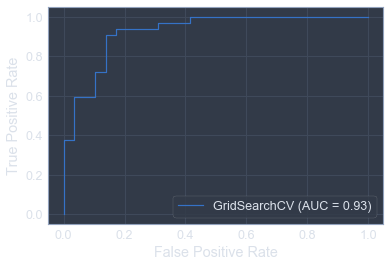

In [38]:
# ROC curve
plot_roc_curve(gs_log_reg, X_test, y_test)

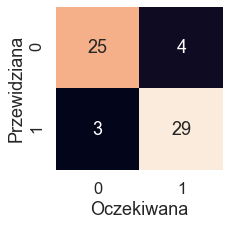

In [39]:
# Confusion Matrix
confusion_matrix(y_test, y_preds)
sns.set(font_scale=  1.5)

def plot_conf_mat(y_test, y_preds):
    """
    Tworzy wykres Confusion Matrix przy użyciu HeatMap'y
    """
    fix, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                    annot = True,
                     cbar = False
                    )
    plt.xlabel("Oczekiwana")
    plt.ylabel("Przewidziana")
    #Znowu ten bug z ucinaniem
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

plot_conf_mat(y_test, y_preds)

In [40]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



# Ewaluacja - Sprawdzanie Krzyżowe

In [41]:
gs_log_reg.best_params_

{'C': 0.20433597178569418, 'solver': 'liblinear'}

In [42]:
# Setup
clf = LogisticRegression(C=gs_log_reg.best_params_["C"],
                        solver=gs_log_reg.best_params_["solver"])

In [43]:
# acc
cv_acc = cross_val_score(clf, X, y, cv = 5, scoring="accuracy")
print(cv_acc)
cv_acc = np.mean(cv_acc)
print(cv_acc)

[0.81967213 0.90163934 0.86885246 0.88333333 0.75      ]
0.8446994535519124


In [44]:
# prec
cv_prec = cross_val_score(clf, X, y, cv = 5, scoring="precision")
print(cv_prec)
cv_prec = np.mean(cv_prec)
print(cv_prec)

[0.775      0.88571429 0.85714286 0.86111111 0.725     ]
0.8207936507936507


In [45]:
# recall
cv_recall = cross_val_score(clf, X, y, cv = 5, scoring="recall")
print(cv_recall)
cv_recall = np.mean(cv_recall)
print(cv_recall)

[0.93939394 0.93939394 0.90909091 0.93939394 0.87878788]
0.9212121212121213


In [46]:
# f1
cv_f1 = cross_val_score(clf, X, y, cv = 5, scoring="f1")
print(cv_f1)
cv_f1 = np.mean(cv_f1)
print(cv_f1)

[0.84931507 0.91176471 0.88235294 0.89855072 0.79452055]
0.8673007976269721


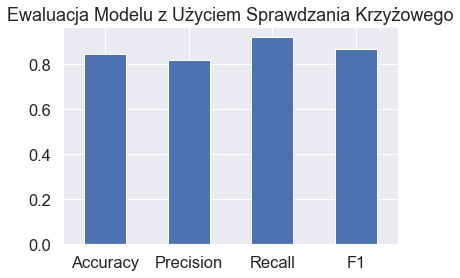

In [47]:
# wizualizacja
cv_metrics = pd.DataFrame({
    "Accuracy" : cv_acc,
    "Precision" : cv_prec,
    "Recall" : cv_recall,
    "F1" : cv_f1}, index=[0])
cv_metrics.T.plot.bar(title = "Ewaluacja Modelu z Użyciem Sprawdzania Krzyżowego", legend = False)
plt.xticks(np.arange(4), rotation = 0)
plt.show()

# Feature Importance

In [48]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [49]:
# Setup
clf = LogisticRegression(C=gs_log_reg.best_params_["C"],
                        solver=gs_log_reg.best_params_["solver"])
clf.fit(X_train, y_train)
print(clf.coef_)

[[ 0.00316728 -0.86044651  0.66067041 -0.01156993 -0.00166374  0.04386107
   0.31275847  0.02459361 -0.6041308  -0.56862804  0.45051628 -0.63609897
  -0.67663373]]


In [50]:
# Mapowanie
feature_dict = dict(zip(df.columns, list(clf.coef_[0])))
feature_dict

{'age': 0.0031672801993431563,
 'sex': -0.8604465072345515,
 'cp': 0.6606704082033799,
 'trestbps': -0.01156993168080875,
 'chol': -0.001663744504776871,
 'fbs': 0.043861071652469864,
 'restecg': 0.31275846822418324,
 'thalach': 0.024593613737779126,
 'exang': -0.6041308000615746,
 'oldpeak': -0.5686280368396555,
 'slope': 0.4505162797258308,
 'ca': -0.6360989676086223,
 'thal': -0.6766337263029825}

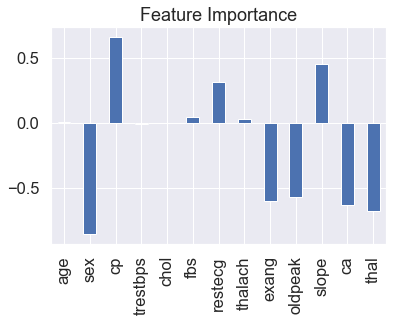

In [51]:
# Graficznie
feature_df = pd.DataFrame(feature_dict, index=[0])
feature_df.T.plot.bar(title = "Feature Importance", legend = False)
plt.show()
# wygląda na to ,że age, trestbps, chol nie wnoszą nic do modelu, można je pominąć
# fbs i thalach wnoszą tak niewiele ,że również można pomyśleć o ich zignorowaniu

# Model Finalny

In [52]:
def user_input():
    params = {
        "age" : np.mean(X_test["age"]),
        "sex" : int(input("Wprowadź płeć \n0 - kobieta \n1 - mężczyzna\n")),
        "cp" : int(input("Wprowadź rodzaj bólu klatki piersiowej\n"  
                         "0 - typical angina\n1 - atypical angina\n"  
                         "2 - Non-anginal pain\n3 - Asymptotic\n")),
        "trestbps" : np.mean(X_test["trestbps"]),
        "chol" : np.mean(X_test["chol"]),
        "fbs" : np.mean(X_test["fbs"]),
        "restecg": int(input("Wprowadź wyniki z resting electrocardiographic\n"
                            "0 - brak wyników\n"
                            "1 - ST-T Wave abnormality\n"
                            "2 - Possible or definite left ventricular hypertrophy\n"
                            )),
        "thalach" : np.mean(X_test["thalach"]),
        "exang" : int(input("Wprowadź czy występuje exercise induced angina\n"
                            "0 - nie\n"
                            "1 - tak\n"
                           )),
        "oldpeak" : float(input("Wprowadź ST depression induced by exercise relative to rest (float)\n")),
        "slope" : int(input("Wprowadź the slope of the peak exercise ST segment\n"
                            "0 - Upsloping\n"
                            "1 - Flatsloping\n"
                            "2 - Downslopins\n"
                           )),
        "ca" : int(input("Wprowadź number of major vessels (0-3) colored by flourosopy\n")),
        "thal" : int(input("Wprowadź thalium stress result\n"
                           "1 - 3: normal\n"
                           "6: fixed defect: used to be defect but ok now\n"
                           "7: reversable defect: no proper blood movement when excercising\n"
                          )),
    }
    return params

In [53]:
user_data = user_input()

Wprowadź płeć 
0 - kobieta 
1 - mężczyzna
1
Wprowadź rodzaj bólu klatki piersiowej
0 - typical angina
1 - atypical angina
2 - Non-anginal pain
3 - Asymptotic
0
Wprowadź wyniki z resting electrocardiographic
0 - brak wyników
1 - ST-T Wave abnormality
2 - Possible or definite left ventricular hypertrophy
0
Wprowadź czy występuje exercise induced angina
0 - nie
1 - tak
0
Wprowadź ST depression induced by exercise relative to rest (float)
0.6
Wprowadź the slope of the peak exercise ST segment
0 - Upsloping
1 - Flatsloping
2 - Downslopins
0
Wprowadź number of major vessels (0-3) colored by flourosopy
0
Wprowadź thalium stress result
1 - 3: normal
6: fixed defect: used to be defect but ok now
7: reversable defect: no proper blood movement when excercising
1


In [56]:
demo = pd.DataFrame(user_data, index=[0])
res = gs_log_reg.predict(demo)
if res[0] == 0:
    print("Masz zdrowe serce")
if res[0] == 1:
    print("Masz chore serce")

Masz chore serce


# Podsumowanie

Kryteria akceptacji nie zostały spełnione, program działa aczkolwiek nie jest gotowy do użytku komercyjnego.